In [1]:
import random
import math
import numpy as np
from scipy.linalg import expm
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn.utils import shuffle
import networkx as nx
import bct.algorithms as bc
from sklearn.tree import DecisionTreeRegressor
from operator import itemgetter

In [2]:
df = pd.read_csv('NetworksData.csv')
df =shuffle(df)

X = df[df.columns[2:9]].drop(['core_periphery'], axis=1)
y = df['cost3']
from sklearn.ensemble import RandomForestRegressor
dtree = RandomForestRegressor(n_estimators=300).fit(X,y)

In [3]:
def evalControlCost(individual):
    sigma = np.std(bc.degrees_und(individual))
    modularity = bc.modularity_und(individual)[1]
    clustering = np.average(bc.clustering_coef_bu(individual))
    avg_Path = bc.charpath(bc.distance_bin(individual),0,0)[0]
    assortativity = bc.assortativity_bin(individual,0)
    #core_periphery = bc.core_periphery_dir(A)[1]
    page_rank = np.max(bc.pagerank_centrality(individual, 0.85))*np.shape(individual)[0]
    
    d={'sigma':sigma,'modularity':modularity,'clustering':clustering,
       'avg_Path':avg_Path,'assortativity':assortativity,'page_rank':page_rank}
    individual_metrics = pd.DataFrame(data=d, index=[1])
    
    cost = dtree.predict(individual_metrics)
    return cost

In [4]:
def rewireNetwork(individual,amount=0.1,tau = 10,p=0.1):
    graph = nx.Graph(individual)
    count = round(amount*nx.number_of_edges(graph))
    k = 0
    while k < count:
        k = k + 1
        
        if random.random()>=p:
            # Graph diffusion choice
            nodes = list(graph.nodes)            
            while list(nx.isolates(graph)):#connect all disconnected nodes
                for disconnected in list(nx.isolates(graph)):
                    graph.add_edge(random.choice(nodes),disconnected)
                    edges = list(graph.edges)
                    chosen_edge = random.choice(edges)
                    graph.remove_edge(chosen_edge[0], chosen_edge[1])
            chosen_node = random.choice(nodes)
            

            L = csr_matrix.toarray(nx.normalized_laplacian_matrix(graph)) # Convert SciPy sparse matrix
            A = csr_matrix.toarray(nx.adjacency_matrix(graph)) # Convert SciPy sparse matrix
            h = expm(-tau*L)

            other_nodes = nodes.copy()
            other_nodes.remove(chosen_node) #remove chosen node from nodes list

            u_1 = np.nanargmax(A[:,chosen_node]/h[:,chosen_node])
            not_A = np.logical_not(A[other_nodes,chosen_node])*1
            temp = np.nanargmax(not_A*h[other_nodes,chosen_node]) 
            u_2 = other_nodes[temp]
            
            if u_1 in list(nx.all_neighbors(graph, chosen_node)):
                if chosen_node < u_1:
                   # delete chosen edge
                    graph.remove_edge(chosen_node, u_1)
                else:
                    graph.remove_edge(u_1, chosen_node)
                # add new edge
                if chosen_node < u_2:
                    graph.add_edge(chosen_node, u_2)
                else:
                    graph.add_edge(u_2, chosen_node)
            else:
                print(u_1, chosen_node, list(nx.all_neighbors(graph, u_1)))
            
        else:
            # random edge choice
            edges = list(graph.edges)
            nonedges = list(nx.non_edges(graph))
            chosen_edge = random.choice(edges)
            chosen_nonedge = random.choice(nonedges)

            # delete chosen edge
            graph.remove_edge(chosen_edge[0], chosen_edge[1])
            # add new edge
            graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])
        
    individual = nx.to_numpy_array(graph,dtype=int) #Adjacency matrix as numpy array
    
    return individual

In [7]:
def main():
    
    fig = plt.figure(figsize=(18,6))
    plt.ion()
    fig.canvas.draw()
    f1 = plt.subplot(131)
    plt.xlabel('Iterations')
    plt.ylabel('Mean Total Control Cost')
    plt.grid(b=True,which='both')
    f2 = plt.subplot(132)
    plt.xlabel('Iterations')
    plt.ylabel('Mean Degree Std. Dev.')
    plt.grid(b=True,which='both')
    f3 = plt.subplot(133)
    plt.xlabel('Iterations')
    plt.ylabel('Mean Modularity')
    plt.rcParams.update({'font.size': 16})
    plt.grid(b=True,which='both')    
    
    p_range = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    rewire_percentage = 0.1
    tau_value = 1
    gmax = 100
    
    labels=[]
    handles =[]
            
    for p_value in p_range:
        # Start Population
        def repeat(times, func,*args,**kargs):
            for ind in range(times):
                yield func(*args,**kargs)
        pop_init = list(map(nx.to_numpy_array,repeat(500,nx.gnm_random_graph, 100, 300)))
        #pop_init = list(map(nx.to_numpy_array,repeat(500,nx.watts_strogatz_graph, 100, 6, 0.3))) # Watts-Strogatz
        #pop_init = list(map(nx.to_numpy_array,repeat(500,nx.barabasi_albert_graph, 100, 3)))  #Barabasi-Albert
               
        # Evaluate the entire population
        fitnesses_init = list(map(evalControlCost, pop_init))
        fits_init = [fit[0] for fit in fitnesses_init]
        
        best = sorted(zip(pop_init,fits_init),key=itemgetter(1))[:100]
        pop = [list(t) for t in zip(*best)][0]
        fits = [list(t) for t in zip(*best)][1]
        
        sigma = list(map(np.std,list(map(bc.degrees_und,pop))))
        modularity = [list(t) for t in zip(*list(map(bc.modularity_und,pop)))][1]

        # Keep track of the number of generations
        g = 0
        
        xdata = [g]
        ydata1 = [np.mean(fits)]
        ydata2 = [np.mean(sigma)]
        ydata3 = [np.mean(modularity)]

        f1.set_xlim(0,gmax)
        f1.set_ylim(0,80)
        line1, = f1.plot(xdata,ydata1)

        f2.set_xlim(0,gmax)
        f2.set_ylim(0,10)
        line2, = f2.plot(xdata,ydata2)

        f3.set_xlim(0,gmax)
        f3.set_ylim(0,1)
        line3, = f3.plot(xdata,ydata3)
        labels.append('p='+str(p_value))
        handles.append(line1)
        
        file = open("results%3s.txt" %p_value,"w+")
        
        # Begin the evolution
        while g < gmax:
            # A new generation
            g = g + 1
            print("-- Generation %i --" % g)

            # Clone all individuals
            offspring = list(pop)

            # Apply mutation on the offspring
            offspring = [rewireNetwork(x,amount=rewire_percentage,tau = tau_value,p=p_value) for x in offspring]
            #offspring = list(map(rewireNetwork,offspring))

            # Evaluate the offspring
            fitnesses2 = list(map(evalControlCost, offspring))
            fits2 = [fit[0] for fit in fitnesses2]

            # Select the next generation individuals
            pop_total = pop + offspring
            fits_total = fits + fits2
            best = sorted(zip(pop_total,fits_total),key=itemgetter(1))[:100]
            pop = [list(t) for t in zip(*best)][0]

            # Gather fitnesses of survivors and print the stats
            fits = [list(t) for t in zip(*best)][1]


            sigma = list(map(np.std,list(map(bc.degrees_und,pop))))
            modularity = [list(t) for t in zip(*list(map(bc.modularity_und,pop)))][1]       

            length = len(pop)
            mean = sum(fits) / length
            sum2 = sum(x*x for x in fits)
            std = abs(sum2 / length - mean**2)**0.5

            print("  Min %s" % min(fits))
            print("  Max %s" % max(fits))
            print("  Avg %s" % mean)
            print("  Std %s" % std)

            xdata.append(g)
            ydata1.append(np.mean(fits))
            ydata2.append(np.mean(sigma))
            ydata3.append(np.mean(modularity))
            fig.legend(handles,labels)

            plt.subplot(131)
            line1.set_xdata(xdata)
            line1.set_ydata(ydata1)
            fig.canvas.draw()

            plt.subplot(132)
            line2.set_xdata(xdata)
            line2.set_ydata(ydata2)
            fig.canvas.draw()

            plt.subplot(133)
            line3.set_xdata(xdata)
            line3.set_ydata(ydata3)
            fig.canvas.draw()
            
            file.write("%2.1f \t %d \t %5.2f \t %3.1f \t %3.2f \n" %(p_value, g, np.mean(fits),np.mean(sigma), np.mean(modularity)))
        file.close()    
    return pop

<IPython.core.display.Javascript object>


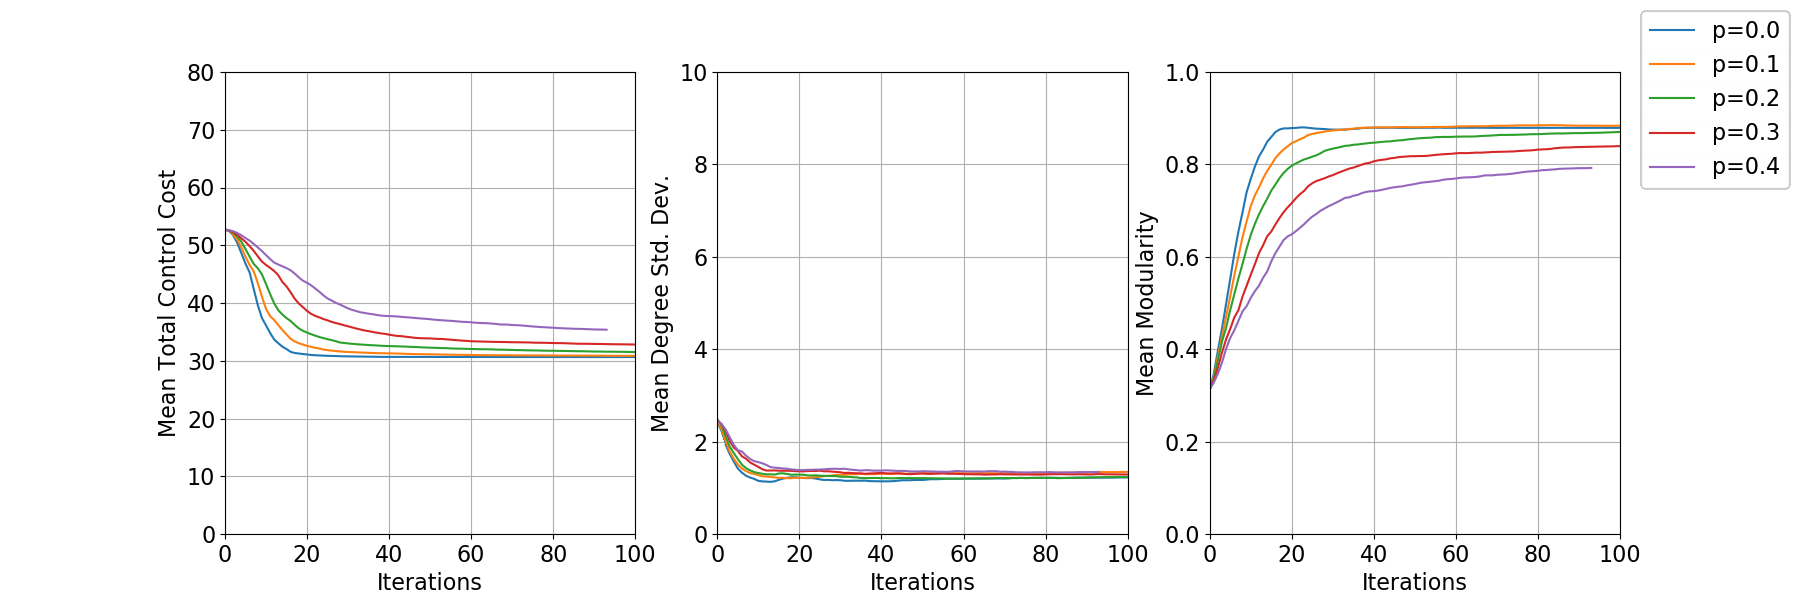

-- Generation 1 --
  Min 51.830615979366655
  Max 52.68193654266668
  Avg 52.47603040788175
  Std 0.17182536763984338


C:\Users\localadmin\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


-- Generation 2 --
  Min 50.828327977666696
  Max 52.40964454184002
  Avg 51.679776303898805
  Std 0.4867102942953315
-- Generation 3 --
  Min 48.54460087443332
  Max 51.17996921526666
  Avg 50.39769438967382
  Std 0.66135062781518
-- Generation 4 --
  Min 46.468810931600025
  Max 49.79440765683332
  Avg 48.60883681066113
  Std 0.8063377865664348
-- Generation 5 --
  Min 44.71082763909998
  Max 47.841672223699966
  Avg 46.81105696767915
  Std 0.5810465702157442
-- Generation 6 --
  Min 41.65355392933337
  Max 46.34957396733331
  Avg 45.28972636489367
  Std 1.1731730388467854
-- Generation 7 --


C:\Users\localadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


  Min 38.16802732560006
  Max 44.45037869373333
  Avg 42.44104107884634
  Std 1.4876973996624674
-- Generation 8 --
  Min 36.90244897836662
  Max 41.55333811253335
  Avg 39.621051968331045
  Std 1.267588422074024
-- Generation 9 --
  Min 34.84981013769997
  Max 38.39408632866672
  Avg 37.39800661883399
  Std 0.8495651010017123
-- Generation 10 --
  Min 33.870225875899976
  Max 37.072573287366616
  Avg 36.1204025728723
  Std 0.7103608419938303
-- Generation 11 --
  Min 31.92534075137221
  Max 35.91651852009998
  Avg 34.8062225943585
  Std 0.9501038031697491
-- Generation 12 --
  Min 31.449014647816686
  Max 34.598079650499976
  Avg 33.668543595800784
  Std 0.625082138766513
-- Generation 13 --
  Min 31.001604229166702
  Max 33.566907535500036
  Avg 33.02506470022286
  Std 0.54274025708909
-- Generation 14 --
  Min 31.001604229166702
  Max 32.93614901539997
  Avg 32.42118569869527
  Std 0.4956420033951254
-- Generation 15 --
  Min 31.001604229166702
  Max 32.616909863866645
  Avg 32.0208

-- Generation 76 --
  Min 30.61276259776672
  Max 30.663202638600062
  Avg 30.64488825128074
  Std 0.008034542694750369
-- Generation 77 --
  Min 30.61276259776672
  Max 30.66243394545006
  Avg 30.644466214043405
  Std 0.007607977295292598
-- Generation 78 --
  Min 30.61276259776672
  Max 30.66243394545006
  Avg 30.644466214043405
  Std 0.007607977295292598
-- Generation 79 --
  Min 30.61276259776672
  Max 30.65651195450006
  Avg 30.64343147054773
  Std 0.006817781161390399
-- Generation 80 --
  Min 30.61276259776672
  Max 30.65651195450006
  Avg 30.64343147054773
  Std 0.006817781161390399
-- Generation 81 --
  Min 30.61276259776672
  Max 30.65651195450006
  Avg 30.64317652518706
  Std 0.006557311685386987
-- Generation 82 --
  Min 30.61276259776672
  Max 30.65651195450006
  Avg 30.64292594803372
  Std 0.0062762955401349995
-- Generation 83 --
  Min 30.61276259776672
  Max 30.656207464233393
  Avg 30.64248845446639
  Std 0.006815641308352542
-- Generation 84 --
  Min 30.61276259776672

-- Generation 45 --
  Min 30.83650351811638
  Max 31.341692046711124
  Avg 31.178316788123674
  Std 0.14894932615714795
-- Generation 46 --
  Min 30.83650351811638
  Max 31.327881054752392
  Avg 31.155439521171303
  Std 0.14447342857715054
-- Generation 47 --
  Min 30.83650351811638
  Max 31.32374389876669
  Avg 31.147958466708168
  Std 0.14280894390529175
-- Generation 48 --
  Min 30.83650351811638
  Max 31.313155956666694
  Avg 31.134614081395068
  Std 0.1373430275102274
-- Generation 49 --
  Min 30.83650351811638
  Max 31.3036429749524
  Avg 31.125958138313432
  Std 0.13432434707697125
-- Generation 50 --
  Min 30.83650351811638
  Max 31.294542106885736
  Avg 31.112123242319104
  Std 0.12730591473206712
-- Generation 51 --
  Min 30.83650351811638
  Max 31.27508238810003
  Avg 31.10370679982809
  Std 0.1248323008200461
-- Generation 52 --
  Min 30.83650351811638
  Max 31.267357528966677
  Avg 31.090292240646008
  Std 0.12142908217186109
-- Generation 53 --
  Min 30.83650351811638
  M

-- Generation 14 --
  Min 34.711375094433286
  Max 38.90314946796669
  Avg 37.997293870435186
  Std 0.62040338076461
-- Generation 15 --
  Min 34.711375094433286
  Max 38.070311240966745
  Avg 37.38237959562816
  Std 0.7697513435711149
-- Generation 16 --
  Min 33.616684301166664
  Max 37.82476683566667
  Avg 36.87602221756296
  Std 0.9610291486623402
-- Generation 17 --
  Min 33.616684301166664
  Max 37.454301596433275
  Avg 36.20441437441729
  Std 0.9959583227568849
-- Generation 18 --
  Min 33.616684301166664
  Max 36.62658734496664
  Avg 35.60374719644232
  Std 0.7841646063052942
-- Generation 19 --
  Min 32.85117815586657
  Max 36.120333640500014
  Avg 35.18131629733764
  Std 0.6608193718714079
-- Generation 20 --
  Min 32.85117815586657
  Max 35.597362962700004
  Avg 34.87353324399365
  Std 0.5874037556054563
-- Generation 21 --
  Min 32.85117815586657
  Max 35.32614431624998
  Avg 34.59796916462249
  Std 0.5141868330825973
-- Generation 22 --
  Min 32.75061750567107
  Max 35.053

-- Generation 84 --
  Min 30.868473228733365
  Max 31.93167281407667
  Avg 31.679298810235395
  Std 0.23421336601757073
-- Generation 85 --
  Min 30.868473228733365
  Max 31.909958833662344
  Avg 31.660316452095582
  Std 0.23663885159230597
-- Generation 86 --
  Min 30.868473228733365
  Max 31.90461131294013
  Avg 31.65069560832858
  Std 0.23420192012626023
-- Generation 87 --
  Min 30.868473228733365
  Max 31.90128988972777
  Avg 31.64585298961144
  Std 0.23146608203442184
-- Generation 88 --
  Min 30.868473228733365
  Max 31.88291881288885
  Avg 31.630064638971472
  Std 0.2316323603340919
-- Generation 89 --
  Min 30.868473228733365
  Max 31.871565425185704
  Avg 31.613585360167754
  Std 0.23080547138943755
-- Generation 90 --
  Min 30.868473228733365
  Max 31.84833948989996
  Avg 31.596278670516234
  Std 0.2309071665717946
-- Generation 91 --
  Min 30.868473228733365
  Max 31.838981888826645
  Avg 31.59448373025814
  Std 0.22940377275857665
-- Generation 92 --
  Min 30.8684732287333

-- Generation 54 --
  Min 32.639159078795466
  Max 34.24355900536662
  Avg 33.699850860030935
  Std 0.4358817859647694
-- Generation 55 --
  Min 32.639159078795466
  Max 34.190216073166646
  Avg 33.651247557644055
  Std 0.4340801924463235
-- Generation 56 --
  Min 32.639159078795466
  Max 34.12281125326668
  Avg 33.58496024618572
  Std 0.430866550852251
-- Generation 57 --
  Min 32.639159078795466
  Max 34.08591531473333
  Avg 33.53043721535784
  Std 0.4219062256510701
-- Generation 58 --
  Min 32.639159078795466
  Max 34.03542521236666
  Avg 33.4730668983744
  Std 0.41908234642961106
-- Generation 59 --
  Min 32.639159078795466
  Max 33.98594203893331
  Avg 33.432409526728904
  Std 0.39990210522644803
-- Generation 60 --
  Min 32.639159078795466
  Max 33.92780648169998
  Avg 33.38064142635401
  Std 0.3857415186011481
-- Generation 61 --
  Min 32.43070611998992
  Max 33.892692765633356
  Avg 33.35901435891759
  Std 0.38696530482240143
-- Generation 62 --
  Min 32.43070611998992
  Max 3

-- Generation 24 --
  Min 37.8544627569
  Max 42.44851232709998
  Avg 41.31879535048873
  Std 0.9570945286931324
-- Generation 25 --
  Min 37.8544627569
  Max 42.03061451410002
  Avg 40.78710027331227
  Std 1.0424342772152477
-- Generation 26 --
  Min 37.71738174486664
  Max 41.548573495100044
  Avg 40.423077202383254
  Std 0.9986439764392716
-- Generation 27 --
  Min 37.71738174486664
  Max 41.14679155286671
  Avg 40.03696955474168
  Std 0.8833031307146443
-- Generation 28 --
  Min 37.71738174486664
  Max 40.7609843174001
  Avg 39.74081759313717
  Std 0.827563521266922
-- Generation 29 --
  Min 36.84626246960002
  Max 40.423997936200074
  Avg 39.39479458953207
  Std 0.7887719027862156
-- Generation 30 --
  Min 36.84626246960002
  Max 40.05548172233335
  Avg 39.066891041970386
  Std 0.7196702726877813
-- Generation 31 --
  Min 36.84626246960002
  Max 39.74271943950004
  Avg 38.812416421350605
  Std 0.6326065293885024
-- Generation 32 --
  Min 36.84626246960002
  Max 39.48842417240004
 

-- Generation 94 --


In [ ]:
%matplotlib notebook
pop = main()

In [ ]:
G = nx.barabasi_albert_graph(100, 3)
print(nx.number_of_edges(G))
nx.draw(G)

In [12]:
plt.rcParams.update({'font.size': 14})

<IPython.core.display.Javascript object>


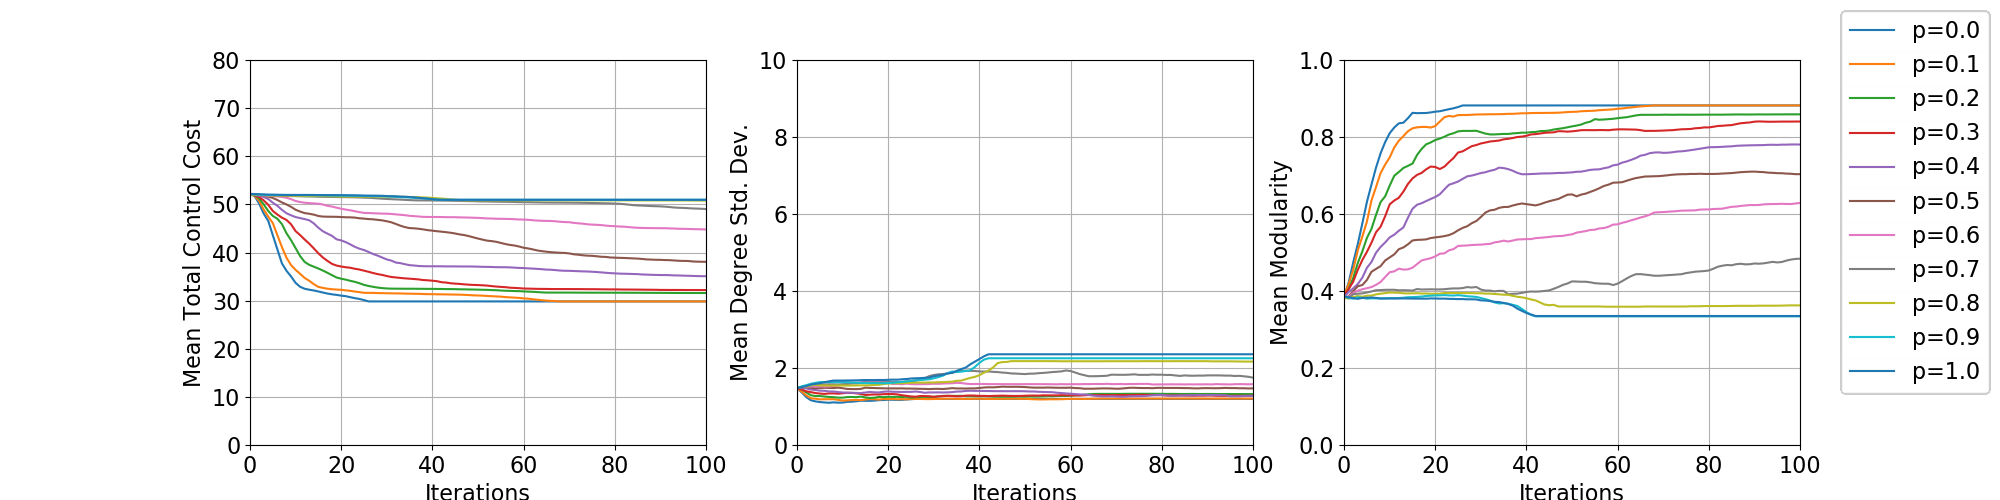

-- Generation 1 --
  Min 50.39851102
  Max 52.00888963
  Avg 51.738937766
  Std 0.3279801775037942


C:\Users\localadmin\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


-- Generation 2 --
  Min 48.30927414
  Max 51.63897485
  Avg 50.18207110829994
  Std 1.1183636590274373
-- Generation 3 --
  Min 45.31616576
  Max 49.19149744
  Avg 48.09705492320001
  Std 0.8205235042103085
-- Generation 4 --
  Min 41.54765154
  Max 47.43741554
  Avg 46.56599719030004
  Std 1.3882026794655424
-- Generation 5 --
  Min 37.21171205
  Max 45.31616576
  Avg 43.604161529899976
  Std 1.6447499063110718
-- Generation 6 --
  Min 36.63368575
  Max 43.13814874
  Avg 40.670957054399985
  Std 1.9584288590405639
-- Generation 7 --


C:\Users\localadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


  Min 35.16668822
  Max 39.34728533
  Avg 37.73630885620004
  Std 1.0627603073327465
-- Generation 8 --
  Min 32.52672983
  Max 37.21171205
  Avg 36.20613657520002
  Std 0.7547591052220419
-- Generation 9 --
  Min 32.52672983
  Max 36.35277617
  Avg 35.030592021100034
  Std 0.9418219932410656
-- Generation 10 --
  Min 31.454403000000003
  Max 35.16668822
  Avg 33.69083381200001
  Std 0.8540720407473646
-- Generation 11 --
  Min 31.22749586
  Max 33.73883713
  Avg 32.86836981760003
  Std 0.5106964459637023
-- Generation 12 --
  Min 31.22749586
  Max 32.69773308
  Avg 32.460800734799996
  Std 0.3567071024119449
-- Generation 13 --
  Min 31.22749586
  Max 32.63948157
  Avg 32.26758640470002
  Std 0.45126186899459264
-- Generation 14 --
  Min 29.83507008
  Max 32.52672983
  Avg 32.108829605400004
  Std 0.49886866879979574
-- Generation 15 --
  Min 29.83507008
  Max 32.39963902
  Avg 31.898984199399997
  Std 0.5749108585078074
-- Generation 16 --
  Min 29.83507008
  Max 32.39963902
  Avg 31

-- Generation 83 --
  Min 29.83507008
  Max 29.83507008
  Avg 29.835070080000026
  Std 7.539457464619588e-07
-- Generation 84 --
  Min 29.83507008
  Max 29.83507008
  Avg 29.835070080000026
  Std 7.539457464619588e-07
-- Generation 85 --
  Min 29.83507008
  Max 29.83507008
  Avg 29.835070080000026
  Std 7.539457464619588e-07
-- Generation 86 --
  Min 29.83507008
  Max 29.83507008
  Avg 29.835070080000026
  Std 7.539457464619588e-07
-- Generation 87 --
  Min 29.83507008
  Max 29.83507008
  Avg 29.835070080000026
  Std 7.539457464619588e-07
-- Generation 88 --
  Min 29.83507008
  Max 29.83507008
  Avg 29.835070080000026
  Std 7.539457464619588e-07
-- Generation 89 --
  Min 29.83507008
  Max 29.83507008
  Avg 29.835070080000026
  Std 7.539457464619588e-07
-- Generation 90 --
  Min 29.83507008
  Max 29.83507008
  Avg 29.835070080000026
  Std 7.539457464619588e-07
-- Generation 91 --
  Min 29.83507008
  Max 29.83507008
  Avg 29.835070080000026
  Std 7.539457464619588e-07
-- Generation 92 --

-- Generation 59 --
  Min 29.83507008
  Max 31.454403000000003
  Avg 30.563669628400042
  Std 0.7007226673859873
-- Generation 60 --
  Min 29.83507008
  Max 31.22749586
  Avg 30.461661681000027
  Std 0.6927230791003557
-- Generation 61 --
  Min 29.83507008
  Max 31.22749586
  Avg 30.405964649800023
  Std 0.6848413734747792
-- Generation 62 --
  Min 29.83507008
  Max 31.22749586
  Avg 30.294570587400006
  Std 0.65473631037671
-- Generation 63 --
  Min 29.83507008
  Max 31.22749586
  Avg 30.18317652500001
  Std 0.602938049181894
-- Generation 64 --
  Min 29.83507008
  Max 31.22749586
  Avg 30.085706720400015
  Std 0.5349525156442921
-- Generation 65 --
  Min 29.83507008
  Max 31.22749586
  Avg 30.00216117360002
  Std 0.4524848204925692
-- Generation 66 --
  Min 29.83507008
  Max 31.22749586
  Avg 29.94646414240002
  Std 0.3777556446781888
-- Generation 67 --
  Min 29.83507008
  Max 31.22749586
  Avg 29.890767111200024
  Std 0.2728586132549738
-- Generation 68 --
  Min 29.83507008
  Max 2

-- Generation 36 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.46989148610001
  Std 0.1676018184146668
-- Generation 37 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.457339783700014
  Std 0.18533818279353573
-- Generation 38 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.45102436130001
  Std 0.18644942443607765
-- Generation 39 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.44141203240001
  Std 0.20083582875665815
-- Generation 40 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.44141203240001
  Std 0.20083582875665815
-- Generation 41 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.42262405000001
  Std 0.22613085866650004
-- Generation 42 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.42051890920001
  Std 0.2261317774044342
-- Generation 43 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.397520645200004
  Std 0.24691430201996883
-- Generation 44 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.395415504400006
  Std 0.

-- Generation 13 --
  Min 37.21171205
  Max 43.13814874
  Avg 41.82726022409998
  Std 1.5860916655637929
-- Generation 14 --
  Min 36.63368575
  Max 43.13814874
  Avg 40.85115572409998
  Std 1.6316200463968489
-- Generation 15 --
  Min 36.63368575
  Max 41.54765154
  Avg 39.82785018960001
  Std 1.5186076836300921
-- Generation 16 --
  Min 36.63368575
  Max 40.64663097
  Avg 38.94756878130003
  Std 1.1057662304204323
-- Generation 17 --
  Min 36.63368575
  Max 39.63865783
  Avg 38.25183145790002
  Std 0.8109888212176231
-- Generation 18 --
  Min 35.16668822
  Max 38.5773297
  Avg 37.62346889350002
  Std 0.7147670727995691
-- Generation 19 --
  Min 35.16668822
  Max 38.44849632
  Avg 37.2817525414
  Std 0.5476658860742186
-- Generation 20 --
  Min 35.16668822
  Max 37.57508494
  Avg 37.08236616190003
  Std 0.4994966443511086
-- Generation 21 --
  Min 35.16668822
  Max 37.21171205
  Avg 36.93949663750008
  Std 0.507149503775001
-- Generation 22 --
  Min 35.16668822
  Max 37.21171205
  Avg

-- Generation 89 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.24774220800004
  Std 0.23934049368083926
-- Generation 90 --
  Min 31.454403000000003
  Max 32.52672983
  Avg 32.22474394400004
  Std 0.24324439424322675
-- Generation 91 --
  Min 31.454403000000003
  Max 32.52124991
  Avg 32.220533662400044
  Std 0.23977810821355983
-- Generation 92 --
  Min 31.454403000000003
  Max 32.36385701
  Avg 32.21500624770005
  Std 0.23572446829534457
-- Generation 93 --
  Min 31.454403000000003
  Max 32.31621575
  Avg 32.21405342250005
  Std 0.23521660943869727
-- Generation 94 --
  Min 31.454403000000003
  Max 32.31621575
  Avg 32.21405342250005
  Std 0.23521660943869727
-- Generation 95 --
  Min 31.454403000000003
  Max 32.31621575
  Avg 32.207817142500055
  Std 0.24063012120535696
-- Generation 96 --
  Min 31.454403000000003
  Max 32.31621575
  Avg 32.20158086250005
  Std 0.2457663010490186
-- Generation 97 --
  Min 31.454403000000003
  Max 32.31621575
  Avg 32.20158086250005
  Std 0.

-- Generation 66 --
  Min 34.82465377
  Max 37.21171205
  Avg 36.41779675270003
  Std 0.5795123450834545
-- Generation 67 --
  Min 34.82465377
  Max 36.90326434
  Avg 36.34154535870002
  Std 0.5517117483600634
-- Generation 68 --
  Min 34.17369671
  Max 36.90326434
  Avg 36.25212157590001
  Std 0.6054451097015298
-- Generation 69 --
  Min 34.17369671
  Max 36.86278289
  Avg 36.206762763200004
  Std 0.6230155393309829
-- Generation 70 --
  Min 34.17369671
  Max 36.66331646
  Avg 36.18995627850001
  Std 0.6185286271282883
-- Generation 71 --
  Min 34.17369671
  Max 36.63368575
  Avg 36.155143199700014
  Std 0.6289573316120758
-- Generation 72 --
  Min 33.96378539
  Max 36.63368575
  Avg 36.113152257200014
  Std 0.6578911256996947
-- Generation 73 --
  Min 33.96378539
  Max 36.63368575
  Avg 36.0789881245
  Std 0.6441120966994581
-- Generation 74 --
  Min 33.96378539
  Max 36.63368575
  Avg 36.0549515351
  Std 0.6406137192547516
-- Generation 75 --
  Min 33.96378539
  Max 36.63368575
  Av

-- Generation 44 --
  Min 40.65982068
  Max 44.63170322
  Avg 44.10338652910011
  Std 0.8083334432096314
-- Generation 45 --
  Min 40.65982068
  Max 44.59820083
  Avg 43.947581070900036
  Std 0.879743422945488
-- Generation 46 --
  Min 40.65982068
  Max 44.59820083
  Avg 43.756336639699974
  Std 0.8966059840335722
-- Generation 47 --
  Min 40.65982068
  Max 44.59820083
  Avg 43.619276384399924
  Std 0.8575595348128342
-- Generation 48 --
  Min 40.65982068
  Max 44.49656621
  Avg 43.40775170809996
  Std 0.8570989875640224
-- Generation 49 --
  Min 40.65982068
  Max 44.49656621
  Avg 43.14847708519996
  Std 0.7944962665382567
-- Generation 50 --
  Min 38.59788894
  Max 44.09477823
  Avg 42.90404806349992
  Std 0.8733664780415409
-- Generation 51 --
  Min 38.59788894
  Max 43.13814874
  Avg 42.67483300989995
  Std 0.8722544462834256
-- Generation 52 --
  Min 37.21171205
  Max 43.13814874
  Avg 42.468087328999964
  Std 1.1099295997123302
-- Generation 53 --
  Min 37.21171205
  Max 43.13814

-- Generation 22 --
  Min 47.68387187
  Max 49.14883861
  Avg 48.770670026100014
  Std 0.41291090355068716
-- Generation 23 --
  Min 47.68387187
  Max 49.14883861
  Avg 48.574067646799996
  Std 0.3541165012067308
-- Generation 24 --
  Min 47.43741554
  Max 48.82133458
  Avg 48.390636803900094
  Std 0.2943643000747109
-- Generation 25 --
  Min 47.43741554
  Max 48.82133458
  Avg 48.231850608200006
  Std 0.24096743708057347
-- Generation 26 --
  Min 47.43741554
  Max 48.30927414
  Avg 48.19613052229999
  Std 0.2599646785114786
-- Generation 27 --
  Min 47.43741554
  Max 48.30927414
  Avg 48.16021095079999
  Std 0.2929928827086433
-- Generation 28 --
  Min 46.16435825
  Max 48.30927414
  Avg 48.11465308609999
  Std 0.36309542286616375
-- Generation 29 --
  Min 46.16435825
  Max 48.30927414
  Avg 48.08522249849998
  Std 0.3701526831664464
-- Generation 30 --
  Min 46.16435825
  Max 48.30927414
  Avg 48.06260259179998
  Std 0.3749079804847922
-- Generation 31 --
  Min 46.16435825
  Max 48.3

-- Generation 100 --
  Min 43.31909302
  Max 45.12442491
  Avg 44.79523201739995
  Std 0.29344763039366356
-- Generation 1 --
  Min 51.55710868
  Max 52.27929342
  Avg 52.079215108199925
  Std 0.20429092210340125
-- Generation 2 --
  Min 51.19153943
  Max 52.27929342
  Avg 51.99227778789996
  Std 0.20074217613249634
-- Generation 3 --
  Min 51.19153943
  Max 52.19580795
  Avg 51.92949627539999
  Std 0.1863324211672808
-- Generation 4 --
  Min 51.19153943
  Max 52.08891864
  Avg 51.8724550143
  Std 0.19589096288819438
-- Generation 5 --
  Min 51.19153943
  Max 52.00888963
  Avg 51.83050192460002
  Std 0.19175477340859953
-- Generation 6 --
  Min 51.19153943
  Max 52.00888963
  Avg 51.80257839500001
  Std 0.182445931229048
-- Generation 7 --
  Min 51.19153943
  Max 51.90365687
  Avg 51.764218431700016
  Std 0.1822856810132285
-- Generation 8 --
  Min 51.19153943
  Max 51.90365687
  Avg 51.74371904030003
  Std 0.18775025889316638
-- Generation 9 --
  Min 51.19153943
  Max 51.90365687
  Av

-- Generation 77 --
  Min 49.14883861
  Max 50.38653085
  Avg 50.24212767219995
  Std 0.2691924657654413
-- Generation 78 --
  Min 49.14883861
  Max 50.38653085
  Avg 50.227166453599956
  Std 0.2709459894584139
-- Generation 79 --
  Min 49.14883861
  Max 50.38653085
  Avg 50.20773551019997
  Std 0.2895996449401201
-- Generation 80 --
  Min 49.14883861
  Max 50.38653085
  Avg 50.165999549299976
  Std 0.31415390879941973
-- Generation 81 --
  Min 49.14883861
  Max 50.38653085
  Avg 50.118357208499965
  Std 0.3317273054012617
-- Generation 82 --
  Min 49.14883861
  Max 50.37947484
  Avg 50.05325099149993
  Std 0.3359691545940853
-- Generation 83 --
  Min 49.14883861
  Max 50.37947484
  Avg 49.950236047499914
  Std 0.3348705479334728
-- Generation 84 --
  Min 48.30927414
  Max 50.37947484
  Avg 49.84658660770001
  Std 0.369494022146753
-- Generation 85 --
  Min 48.30927414
  Max 50.01602839
  Avg 49.77728042690007
  Std 0.3681661463580075
-- Generation 86 --
  Min 48.30927414
  Max 50.0160

-- Generation 54 --
  Min 50.85986465
  Max 50.85986465
  Avg 50.859864650000056
  Std 1.3486991523486091e-06
-- Generation 55 --
  Min 50.85986465
  Max 50.85986465
  Avg 50.859864650000056
  Std 1.3486991523486091e-06
-- Generation 56 --
  Min 50.85986465
  Max 50.85986465
  Avg 50.859864650000056
  Std 1.3486991523486091e-06
-- Generation 57 --
  Min 50.52841176
  Max 50.85986465
  Avg 50.85655012110006
  Std 0.03297914612972809
-- Generation 58 --
  Min 50.52841176
  Max 50.85986465
  Avg 50.853235592200065
  Std 0.04640340456913328
-- Generation 59 --
  Min 50.52841176
  Max 50.85986465
  Avg 50.853235592200065
  Std 0.04640340456913328
-- Generation 60 --
  Min 50.52841176
  Max 50.85986465
  Avg 50.853235592200065
  Std 0.04640340456913328
-- Generation 61 --
  Min 50.52841176
  Max 50.85986465
  Avg 50.853235592200065
  Std 0.04640340456913328
-- Generation 62 --
  Min 50.52841176
  Max 50.85986465
  Avg 50.853235592200065
  Std 0.04640340456913328
-- Generation 63 --
  Min 50.

  Min 50.95359039
  Max 51.90365687
  Avg 51.62329854930011
  Std 0.29790907381760245
-- Generation 32 --
  Min 50.95359039
  Max 51.90365687
  Avg 51.57835422610012
  Std 0.31456544397114616
-- Generation 33 --
  Min 50.95359039
  Max 51.90365687
  Avg 51.49932457120002
  Std 0.32428015147134764
-- Generation 34 --
  Min 50.95359039
  Max 51.82094367
  Avg 51.471135507299984
  Std 0.31960455664139
-- Generation 35 --
  Min 50.95359039
  Max 51.76648142
  Avg 51.43247562119998
  Std 0.3225269498425037
-- Generation 36 --
  Min 50.95359039
  Max 51.74852339
  Avg 51.34959709439996
  Std 0.3263024519486986
-- Generation 37 --
  Min 50.95359039
  Max 51.63897485
  Avg 51.280258087899945
  Std 0.31653805288963643
-- Generation 38 --
  Min 50.95359039
  Max 51.63897485
  Avg 51.259696554099946
  Std 0.31482468826025595
-- Generation 39 --
  Min 50.95359039
  Max 51.63897485
  Avg 51.16815265669994
  Std 0.2863314764985033
-- Generation 40 --
  Min 50.95359039
  Max 51.63897485
  Avg 51.0744

-- Generation 7 --
  Min 51.19153943
  Max 52.19580795
  Avg 51.97944435549999
  Std 0.12504169401515897
-- Generation 8 --
  Min 51.19153943
  Max 52.00888963
  Avg 51.96592531240001
  Std 0.11141008079571788
-- Generation 9 --
  Min 51.19153943
  Max 52.00888963
  Avg 51.96592531240001
  Std 0.11141008079571788
-- Generation 10 --
  Min 51.19153943
  Max 52.00888963
  Avg 51.96487298480001
  Std 0.1114962464504803
-- Generation 11 --
  Min 51.19153943
  Max 52.00888963
  Avg 51.96255419340002
  Std 0.11149563876151343
-- Generation 12 --
  Min 51.19153943
  Max 52.00888963
  Avg 51.96255419340002
  Std 0.11149563876151343
-- Generation 13 --
  Min 51.19153943
  Max 52.00888963
  Avg 51.955314537600024
  Std 0.11765204130556675
-- Generation 14 --
  Min 51.19153943
  Max 52.00888963
  Avg 51.95437769200002
  Std 0.11759468496666574
-- Generation 15 --
  Min 50.95359039
  Max 52.00888963
  Avg 51.93327170720003
  Std 0.18263384348825254
-- Generation 16 --
  Min 50.95359039
  Max 52.00

-- Generation 84 --
  Min 50.95359039
  Max 50.95359039
  Avg 50.953590389999945
  Std 2.431401974483864e-06
-- Generation 85 --
  Min 50.95359039
  Max 50.95359039
  Avg 50.953590389999945
  Std 2.431401974483864e-06
-- Generation 86 --
  Min 50.95359039
  Max 50.95359039
  Avg 50.953590389999945
  Std 2.431401974483864e-06
-- Generation 87 --
  Min 50.95359039
  Max 50.95359039
  Avg 50.953590389999945
  Std 2.431401974483864e-06
-- Generation 88 --
  Min 50.95359039
  Max 50.95359039
  Avg 50.953590389999945
  Std 2.431401974483864e-06
-- Generation 89 --
  Min 50.95359039
  Max 50.95359039
  Avg 50.953590389999945
  Std 2.431401974483864e-06
-- Generation 90 --
  Min 50.95359039
  Max 50.95359039
  Avg 50.953590389999945
  Std 2.431401974483864e-06
-- Generation 91 --
  Min 50.95359039
  Max 50.95359039
  Avg 50.953590389999945
  Std 2.431401974483864e-06
-- Generation 92 --
  Min 50.95359039
  Max 50.95359039
  Avg 50.953590389999945
  Std 2.431401974483864e-06
-- Generation 93 --

In [17]:
%matplotlib notebook
pop = main()